## Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings
warnings.filterwarnings("ignore")

## Fetching Data from API

In [2]:
api_key = "288YIOVTFR0C353B"

In [3]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=NVDA&interval=5min&apikey={api_key}&outputsize=full&extended_hours=false"

In [4]:
r = requests.get(url)

In [5]:
data = r.json()

In [6]:
df = pd.DataFrame(data['Time Series (5min)']).T

## Preprocessing and cleaning data

In [7]:
df.columns = ['open','high','low','close','volume']

In [8]:
df.index = pd.to_datetime(df.index)

In [9]:
df.sort_index(inplace = True)

In [10]:
df.head()

,open,high,low,close,volume
2024-11-25 09:30:00,141.9802,142.0402,139.2911,139.4099,14438418
2024-11-25 09:35:00,139.3904,140.5303,138.5404,140.5053,10038179
2024-11-25 09:40:00,140.5053,140.5188,138.9004,139.1104,6517319
2024-11-25 09:45:00,139.1020,139.6004,138.2505,138.4255,7475329
2024-11-25 09:50:00,138.4305,139.0704,136.6706,136.8984,12360933


In [11]:
df1 = df.loc["2024-12-13 04:00:00":,:]  # To get data of one week to last date in the dataset

In [12]:
# converting all the columns to numeric from objects for further analysis

df1['open'] = pd.to_numeric(df1['open'], errors= "coerce")
df1['close'] = pd.to_numeric(df1['close'], errors= "coerce")
df1['high'] = pd.to_numeric(df1['high'], errors= "coerce")
df1['low'] = pd.to_numeric(df1['low'], errors= "coerce")
df1['volume'] = pd.to_numeric(df1['volume'], errors= "coerce")

## Calculation of volatility

In [13]:
df1['change'] = np.log(df1['close']/df1['close'].shift())

In [14]:
df1['volatility'] = df1.change.rolling(10).std().shift()

In [15]:
df1.head()

,open,high,low,close,volume,change,volatility
2024-12-13 09:30:00,138.9400,139.6000,138.030,138.2000,7290617,NaN,NaN
2024-12-13 09:35:00,138.2289,138.9600,137.670,137.8100,4986842,-0.002826,NaN
2024-12-13 09:40:00,137.8480,138.2196,137.485,138.1900,4185952,0.002754,NaN
2024-12-13 09:45:00,138.1800,138.5300,137.750,137.7994,3261144,-0.002831,NaN
2024-12-13 09:50:00,137.7800,138.7550,137.780,138.4861,3162294,0.004971,NaN


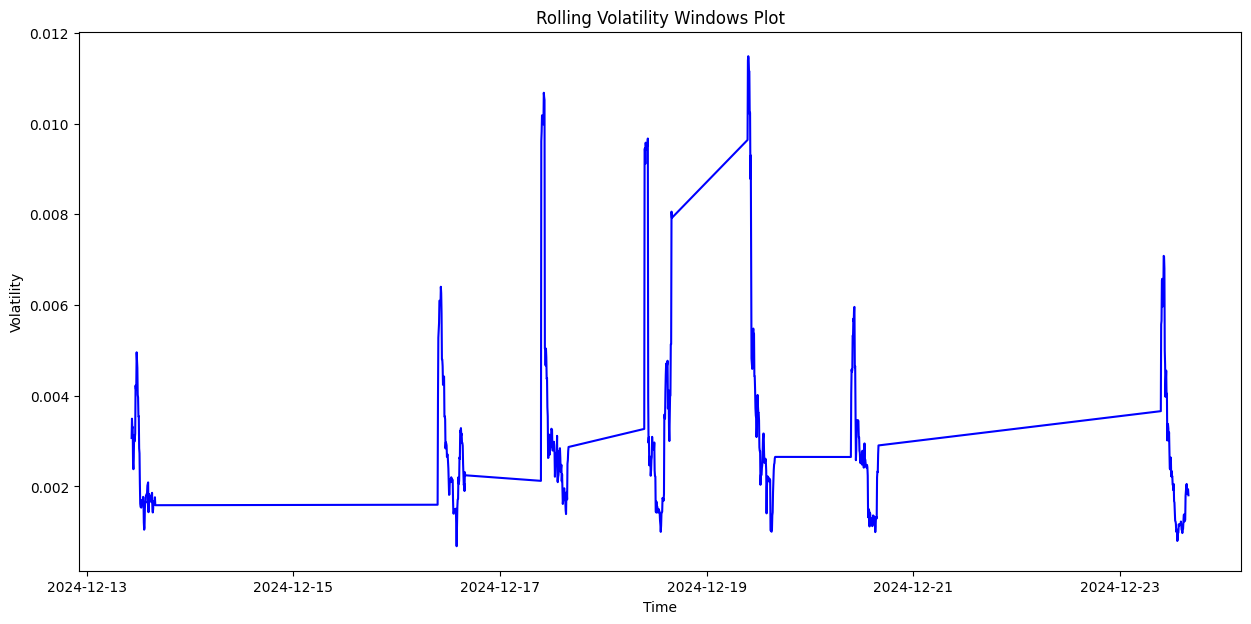

In [16]:
plt.figure(figsize = (15,7))

plt.plot(df1.index, df1['volatility'], c = 'b')
plt.title("Rolling Volatility Windows Plot")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.show()

Always a high volatility in the inetial hours of trading

In [18]:
# VWAP Calculation

sample = pd.DataFrame()
sample.index = df1.index[:78]
sample['price_vol'] = df1['close'][:78]*df1['volume'][:78]
sample['cum_price_vol'] = sample['price_vol'].cumsum()
sample['cum_vol'] = df1['volume'][:78].cumsum()
sample['VWAP'] = sample['cum_price_vol']/sample['cum_vol']
sample['close'] = df1['close'][:78]

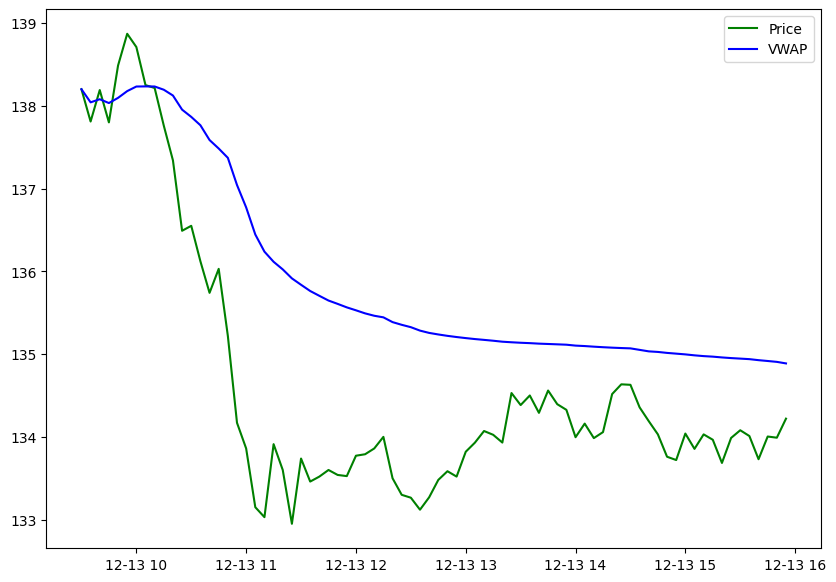

In [41]:
plt.figure(figsize = (10,7))

plt.plot(sample.index, sample['close'], c = 'g', label = "Price")
plt.plot(sample.index, sample['VWAP'], c = 'b', label = "VWAP")
plt.legend()

plt.show()

In [20]:
# Moving Average Calculation

In [21]:
df1['ema_20'] = df1['close'].ewm(span=20, adjust=False).mean()
df1['ema_50'] = df1['close'].ewm(span=50, adjust=False).mean()

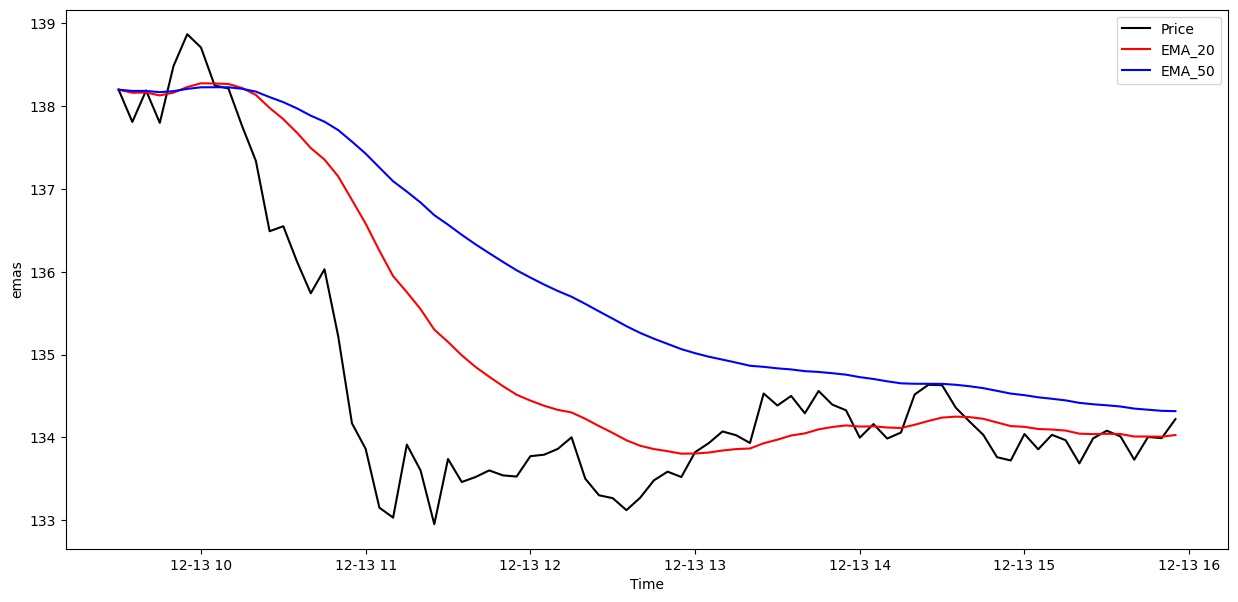

In [22]:
# plotting emas 
plt.figure(figsize = (15,7))

plt.plot(df1.index[:78], df1['close'][:78], label = "Price", c = 'black')
plt.plot(df1.index[:78], df1['ema_20'][:78], label = "EMA_20", c = 'r')
plt.plot(df1.index[:78], df1['ema_50'][:78], label = "EMA_50", c = 'b')
plt.xlabel("Time")
plt.ylabel("emas")
plt.legend()
plt.show()

## Handling missing values and outliers
We can Drop some initial missing values which caused due to calculation of rolling Standard deviation for rolling volatility.

## Detecting Outliers

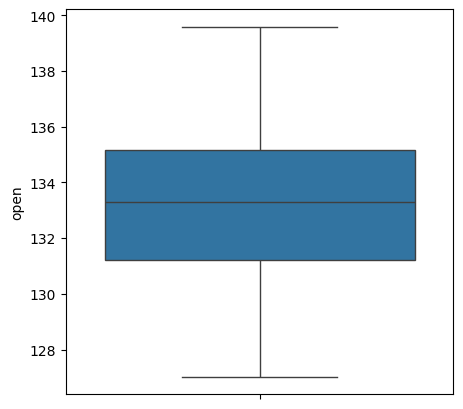

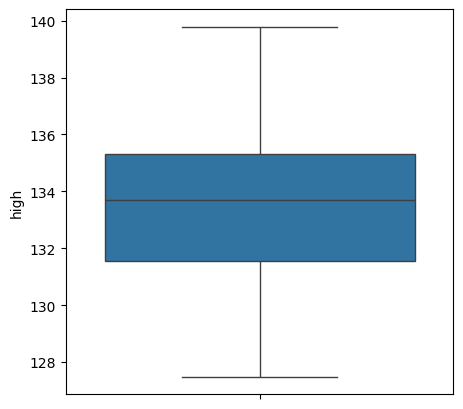

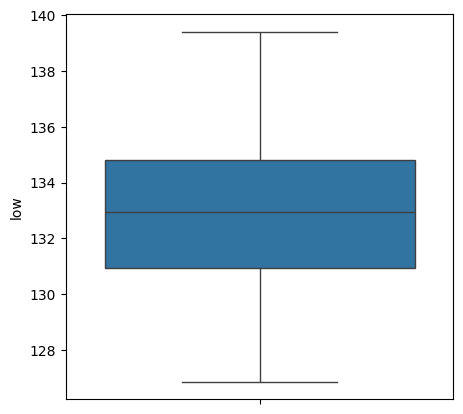

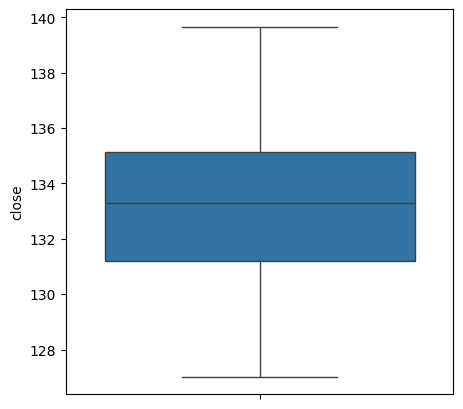

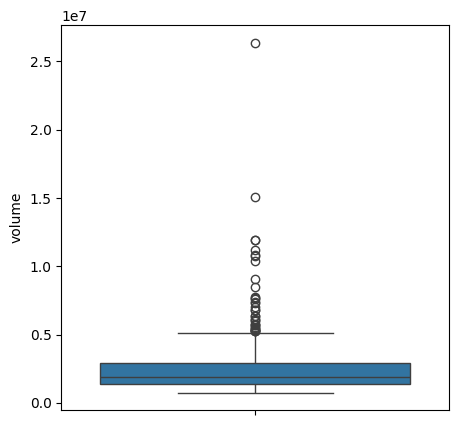

In [25]:
for i in df1.columns[:5]:
    plt.figure(figsize = (5,5))
    sns.boxplot(df1[i])
    plt.show()

__Outliers above upper fence in volume implies:__
1. High Volume Activity: The volume values above the upper bound indicate that there was unusually high trading activity at those points.
2. Potential Market Events: These outliers could be the result of significant market events like news, earnings announcements, or other factors that caused a spike in trading volume.
3. Rare Occurrences: Outliers are rare events. A high volume outside the usual range suggests that something unusual happened, such as a sudden surge in interest for a stock, which may warrant further investigation.

We can smoothen the effect of these outliers by using ema or simple moving average but can not remove or edit because they play a very impotant role in stock analysis

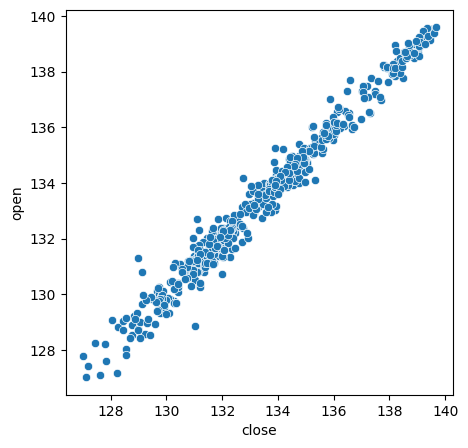

Correlation between Open and Close price is 0.9891759093853648
This impies if open price increases there is 98% chance that close price will also increase


In [28]:
# Correlation between open and closing price

plt.figure(figsize = (5,5))
sns.scatterplot(x = df1['close'], y = df1['open'])

plt.show()
print(f"Correlation between Open and Close price is {df1['close'].corr(df1['open'])}\nThis impies if open price increases there is 98% chance that close price will also increase")

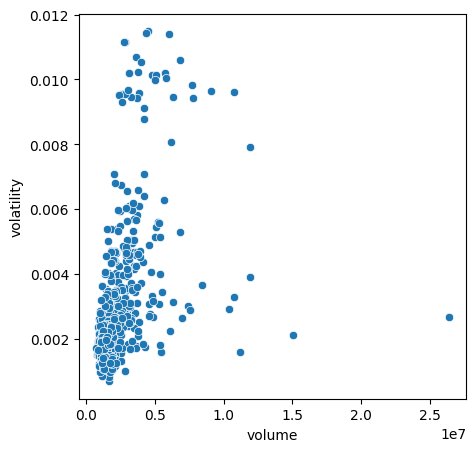

Correlation between Open and Close price is 0.4152245475235615
This impies if Volume increases there is 41% chance that Volatility will also increase


In [29]:
# Correlation between volume and volatility

plt.figure(figsize = (5,5))
sns.scatterplot(x = df1['volume'], y = df1['volatility'])

plt.show()
print(f"Correlation between Open and Close price is {df1['volume'].corr(df1['volatility'])}\nThis impies if Volume increases there is 41% chance that Volatility will also increase")

## Standard deviation Calculation

In [31]:
df1.describe().loc["std"]

open          2.855359e+00
high          2.815421e+00
low           2.896319e+00
close         2.857192e+00
volume        1.988233e+06
change        3.766132e-03
volatility    2.144057e-03
ema_20        2.610440e+00
ema_50        2.311106e+00
Name: std, dtype: float64

## Skewness Calculation

In [32]:
skewness_all = df1.skew()

In [33]:
skewness_all

open          0.306433
high          0.326560
low           0.307476
close         0.315152
volume        5.065447
change       -0.145057
volatility    2.003761
ema_20        0.448831
ema_50        0.489569
dtype: float64

## The relationship between volume and volatility 
- When trading volume increases (more people are buying and selling), there are more trades happening in the market. This means the price of a stock or asset can change more quickly and by bigger amounts, causing higher volatility (the price is moving up and down a lot).
- So, volatility increases with volume because when lots of people are trading, there’s more buying pressure and selling pressure, which can cause the price to swing more. This leads to larger price changes within a short time.